In [1]:
# SETUP
import matplotlib.pyplot as plt
from sklearn.metrics import PrecisionRecallDisplay
import numpy as np
import json
import requests
import pandas as pd

In [2]:
QRELS_FILE = 'q1_rels.txt' # 1
QUERY_URL = 'http://localhost:8983/solr/book_no_schema/query?q=(mystery%20OR%20thriller)%20AND%20(surpri*)%20AND%20(-rape%20AND%20-gore%20AND%20-sexual~1)&q.op=OR&defType=edismax&indent=true&qf=genre%20mood%20sensitivity%20buzzwords&wt=json' 
QUERY_URL_BOOST = 'http://localhost:8983/solr/book_no_schema/query?q=(mystery%20OR%20thriller)%20AND%20(surpri*)%20AND%20(-rape%20AND%20-gore%20AND%20-sexual~1)&q.op=OR&defType=edismax&indent=true&qf=genre%5E10%20mood%20sensitivity%5E20%20buzzwords&wt=json' 

#QRELS_FILE = 'disgust_qrels.txt' # 2
#QUERY_URL = 'http://localhost:8983/solr/books/query?q=disgust*&q.op=OR&defType=edismax&indent=true&qf=review%20mood&wt=json' #disgust
#QUERY_URL_BOOST = 'http://localhost:8983/solr/books/query?q=disgust*&q.op=OR&defType=edismax&indent=true&qf=review%5E2.5%20mood%5E5&wt=json'

In [3]:
# Read qrels to extract relevant documents
relevant = list(map(lambda el: el.strip(), open(QRELS_FILE).readlines()))
# Get query results from Solr instance
normal_results = requests.get(QUERY_URL).json()['response']['docs']
boosted_results = requests.get(QUERY_URL_BOOST).json()['response']['docs']

In [9]:
# METRICS TABLE
# Define custom decorator to automatically calculate metric based on key
metrics = {}
metric = lambda f: metrics.setdefault(f.__name__, f)

@metric
def ap(results, relevant):
    """Average Precision"""
    precision_values = [
        len([
            doc 
            for doc in results[:idx]
            if doc['id'] in relevant
        ]) / idx 
        for idx in range(1, len(results))
    ]
    return sum(precision_values)/len(precision_values)

@metric
def p10(results, relevant, n=10):
    """Precision at N"""
    return len([doc for doc in results[:n] if doc['id'] in relevant])/n

def calculate_metric(key, results, relevant):
    return metrics[key](results, relevant)

# Define metrics to be calculated
evaluation_metrics = {
    'ap': 'Average Precision',
    'p10': 'Precision at 10 (P@10)'
}

# Calculate all metrics and export results as LaTeX table
df = pd.DataFrame([['Metric','Value']] +
    [
        [evaluation_metrics[m], calculate_metric(m, boosted_results, relevant)]
        for m in evaluation_metrics
    ]
)

with open('boosted_no_schema_q1_python.tex','w') as tf:
    tf.write(df.to_latex())

C:\Users\melis\AppData\Local\Temp\ipykernel_1916\2869921338.py:42: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  tf.write(df.to_latex())


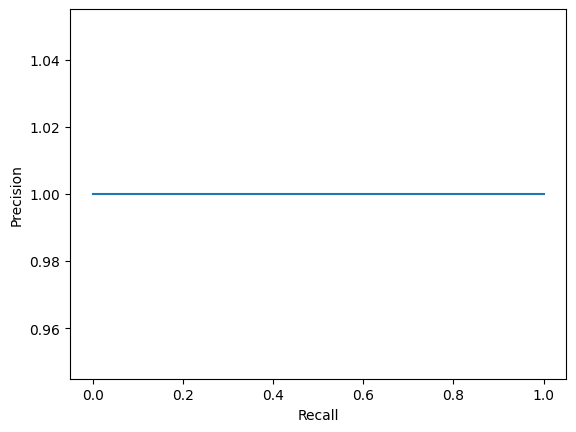

In [10]:
# PRECISION-RECALL CURVE
# Calculate precision and recall values as we move down the ranked list
precision_values = [
    len([
        doc 
        for doc in boosted_results[:idx]
        if doc['id'] in relevant
    ]) / idx 
    for idx, _ in enumerate(boosted_results, start=1)
]

recall_values = [
    len([
        doc for doc in boosted_results[:idx]
        if doc['id'] in relevant
    ]) / len(relevant)
    for idx, _ in enumerate(boosted_results, start=1)
]

precision_recall_match = {k: v for k,v in zip(recall_values, precision_values)}

# Extend recall_values to include traditional steps for a better curve (0.1, 0.2 ...)
recall_values.extend([step for step in np.arange(0.1, 1.1, 0.1) if step not in recall_values])
recall_values = sorted(set(recall_values))

# Extend matching dict to include these new intermediate steps
for idx, step in enumerate(recall_values):
    if step not in precision_recall_match:
        if recall_values[idx-1] in precision_recall_match:
            precision_recall_match[step] = precision_recall_match[recall_values[idx-1]]
        else:
            precision_recall_match[step] = precision_recall_match[recall_values[idx+1]]

disp = PrecisionRecallDisplay([precision_recall_match.get(r) for r in recall_values], recall_values)
disp.plot()
plt.savefig('precision_recall_boosted_no_schema_q1_python.png')
